In [1]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#declare sampling rate
sampling_rate = 16000
#get the audio path of all the audios
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [3]:
#Read the data and get the shapes of the dataframe
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')

#lets only keep audio files > 8 sec
bird_df = bird_df[bird_df['duration_secs_32000'] >= 8]
print(bird_df.shape)

bird_df.head(2)

(794, 9)


,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train


In [4]:
# Assuming you have your dataframe loaded into the variable "df"
bird_df = pd.get_dummies(bird_df, columns=['continent'], prefix='continent')
bird_df.head(2)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,data,continent_AFRICA,continent_AMERICAS,continent_ASIA,continent_EUROPE,continent_UNKNOWN
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,train,0,0,0,1,0
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,train,0,0,0,1,0


In [5]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
print("train data:",bird_train_df.shape)

#Gather the separate validation set from the csv
bird_val_df =  bird_df[bird_df['data'] == 'val']
print("validation data:",bird_val_df.shape)

train data: (560, 13)
validation data: (234, 13)


In [6]:
#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [7]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 8.0,
      hop_size_s: float = 4.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=False)
    return framed_audio

In [8]:
#extract mfcc from frames
def extract_mfcc_and_chroma_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20, n_chroma=12):
  mfcc_frames = []
  chroma_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    # Extract chroma from the main audio frame
    chroma = librosa.feature.chroma_stft(y=frame, sr=sample_rate, n_chroma=n_chroma)

    # Transpose the chroma matrix
    transposed_chroma = chroma.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #lets get chroma
    chroma_frames.append(transposed_chroma)

    #append the labels for every frame
    target_label.append(class_label)

  #Combine MFCC and chroma features for each frame
  combined_frames = [np.hstack((mfcc, chroma)) for mfcc, chroma in zip(mfcc_frames, chroma_frames)]

  return combined_frames,target_label

In [10]:
#Define the function to extract the final features (MFCC and Chroma)
def extract_final_features_from_dataframe(df, n_mfcc=20, n_chroma=12):
    mfcc_and_chroma_frames = []
    target_labels = []

    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']
        audio = load_audio(file_name)
        framed_audio = frame_audio(audio)

        # Extract MFCC and chroma features for each frame
        combined_frames, target_label = extract_mfcc_and_chroma_from_frames(framed_audio, class_label, n_mfcc=n_mfcc, n_chroma=n_chroma)
        mfcc_and_chroma_frames.extend(combined_frames)
        target_labels.extend(target_label)

    return mfcc_and_chroma_frames, target_labels

In [11]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [12]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [13]:
#lets scale the data, so that the features are all in a uniform range between 0 and 1
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

In [14]:
# Define the number of MFCC and chroma features
n_mfcc = 20
n_chroma = 12

# Extract the MFCC embeddings and labels from the model
mfcc_chroma_embeddings, labels = extract_final_features_from_dataframe(bird_train_df, n_mfcc=n_mfcc, n_chroma=n_chroma)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [15]:
mfcc_chroma_embeddings[:1]

[array([[-6.4085791e+02,  6.4677185e+01, -6.2988552e+01, ...,
          1.0000000e+00,  9.9809223e-01,  7.6298338e-01],
        [-3.6702380e+02,  6.1163193e+01, -6.4072556e+01, ...,
          5.6058109e-01,  6.0619849e-01,  3.5118517e-01],
        [-2.9250320e+02,  5.8884689e+01, -6.7405975e+01, ...,
          5.3317761e-01,  6.8673980e-01,  4.8911238e-01],
        ...,
        [-2.9101746e+02,  6.1561676e+01, -5.7485897e+01, ...,
          4.6445101e-01,  5.5438536e-01,  4.6599326e-01],
        [-2.9130588e+02,  5.3773117e+01, -5.4283733e+01, ...,
          5.1427150e-01,  4.0353301e-01,  3.8639456e-01],
        [-3.2962814e+02,  4.8120449e+01, -4.9139000e+01, ...,
          3.6611986e-01,  2.4415076e-01,  2.3253688e-01]], dtype=float32)]

In [21]:
#verify the shapes
x_train = np.array(mfcc_chroma_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(4555, 251, 32)
(4555,)


In [16]:
#lets extract the embeddings
val_mfcc_chroma_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [22]:
val_mfcc_chroma_embeddings[:1]

[array([[-340.6138    ,  127.00826   ,   44.271774  , ...,    0.99856013,
            1.        ,    0.818858  ],
        [-283.6167    ,  124.63982   ,   38.063232  , ...,    1.        ,
            0.855522  ,    0.63253754],
        [-275.97565   ,  124.30683   ,   34.929054  , ...,    1.        ,
            0.5863867 ,    0.74561006],
        ...,
        [-273.98123   ,  136.26807   ,   51.75334   , ...,    1.        ,
            0.5952693 ,    0.4015345 ],
        [-267.34256   ,  130.73344   ,   47.949898  , ...,    1.        ,
            0.61924434,    0.3655047 ],
        [-283.4364    ,  116.29227   ,   34.949898  , ...,    1.        ,
            0.7586159 ,    0.56880885]], dtype=float32)]

In [23]:
#verify the val data shapes
x_val = np.array(val_mfcc_chroma_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(1785, 251, 32)
(1785,)


In [24]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [25]:
#lets verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(4555, 3)
(1785, 3)


In [26]:
#call the scale function and make all the features in a uniform scale
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [27]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

(4555, 251, 32)
(4555, 3)
(1785, 251, 32)
(1785, 3)


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def train_stacked_model(x_train, y_train, x_val, y_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100):
    input_shape = x_train.shape[1:]  # Shape of one sample in x_train

    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM layer
    lstm_output = LSTM(256)(inputs)

    # BatchNormalization
    batch_norm_output = BatchNormalization()(lstm_output)

    # Dropout layer
    dropout_1 = Dropout(0.2)(batch_norm_output)

    # Dense layers
    dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
    dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_1)

    # Dropout layers
    dropout_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(48, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)
    dropout_3 = Dropout(0.4)(dense_3)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(dropout_3)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define the early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

    return model, history


In [29]:
#call the LSTM model
model, history = train_stacked_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.002, batch_size=32, n_classes=3, epochs=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 251, 32)]         0         
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

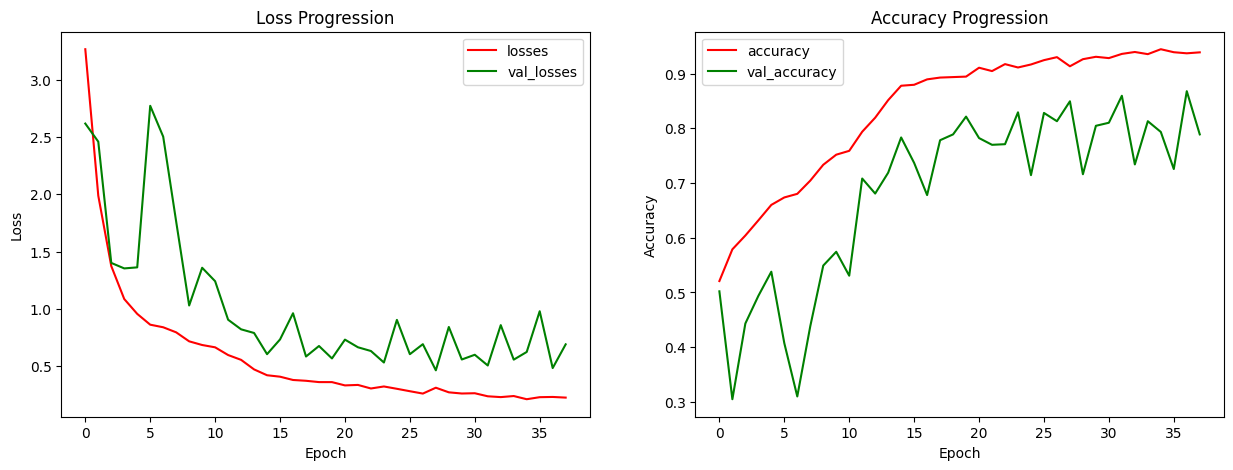

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plot the training and validation accuracy and losses
    num_epochs = len(history.history['loss'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
    axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Progression')
    axes[0].legend()

    axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
    axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Progression')
    axes[1].legend()
    plt.show()

#call the plot function
plot_accuracy(history)

In [32]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(history.model.predict(x_shuffled_train), axis=-1)
test_pred = np.argmax(history.model.predict(x_shuffled_val), axis=-1)
print(test_pred_train)
print(test_pred)

56/56 [==============================] - 13s 228ms/step
[2 2 0 ... 2 2 1]
[0 0 1 ... 0 1 2]


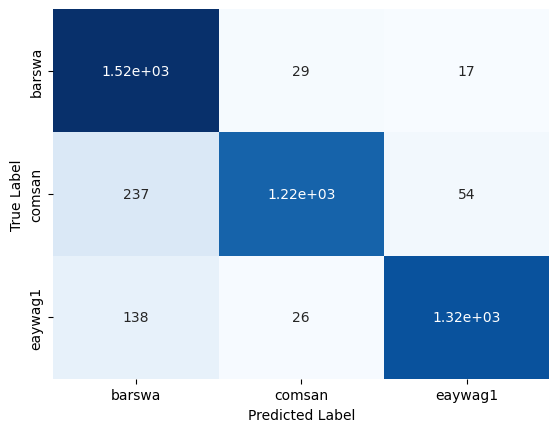

              precision    recall  f1-score   support

           0      0.802     0.971     0.878      1561
           1      0.957     0.808     0.876      1513
           2      0.949     0.889     0.918      1481

    accuracy                          0.890      4555
   macro avg      0.902     0.889     0.891      4555
weighted avg      0.901     0.890     0.890      4555



In [33]:
#plot the  confusion matrix on the train dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

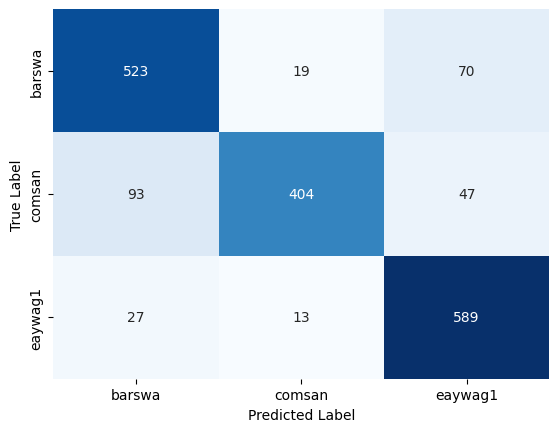

              precision    recall  f1-score   support

           0      0.813     0.855     0.833       612
           1      0.927     0.743     0.824       544
           2      0.834     0.936     0.882       629

    accuracy                          0.849      1785
   macro avg      0.858     0.845     0.847      1785
weighted avg      0.855     0.849     0.848      1785



In [34]:
#plot the confusion matrix on the test dataset
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

In [35]:
model.save('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/HS/RNN/LSTM/4a.lstm_mfccchroma.model.h5')